In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import os
import numpy as np
import csv
import re
import itertools
import copy
from sklearn import *
from collections import Counter

/Users/simon/work/MachineLearning/simbad-colours/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/simon/work/MachineLearning/simbad-colours/venv/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/simon/work/MachineLearning/simbad-colours/venv/lib/python3.5/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis i

In [2]:
def iterate_rows():
    filename = 'simbadresult.csv'
    if not os.path.isfile(filename):
        compressed_filename = '{}.xz'.format(filename)
        if os.path.isfile(compressed_filename):
            raise OSError('Found compressed file: {}. Uncompress with unxz'.format(
                compressed_filename))
        else:
            raise OSError('Cannot find {}.'.format(filename))

    with open('simbadresult.csv') as infile:
        reader = csv.DictReader(infile)
        for row in reader:
            yield row

In [3]:
# SPTYPE_REGEX = re.compile(r'[OBAFGKM][0-9](I|II|III|IV|V)')
# For now only handle main sequence stars
SPTYPE_REGEX = re.compile(r'(?P<typ>[OBAFGKM])(?P<cls>[0-9](\.[0-9]+)?)V')
SPTYPES = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
SP_TYPE_MAPPING = {value: index for (index, value) in enumerate(SPTYPES)}


def parse_sptype(sptype):
    match = SPTYPE_REGEX.match(sptype)
    if match:
        return match.group(0)

In [4]:
def spclass_to_number(cls):
    match = SPTYPE_REGEX.match(cls)
    assert match
    int_part = SP_TYPE_MAPPING[match.group('typ')]
    float_part = float(match.group('cls')) / 10.0
    return int_part + float_part

In [5]:
def number_to_spclass(num):
    int_part = int(num)
    float_part = float((num % 1) * 10)
    label = SPTYPES[int_part] + "{:.1f}".format(float_part) + 'V'
    if '.0' in label:
        return label.replace('.0', '')
    return label

In [6]:
required_bands = ['B', 'V', 'R', 'J', 'H', 'K']
wavelength_centres = {
    'U': 365,
    'B': 445,
    'V': 551,
    'J': 1220,
    'H': 1630,
    'K': 2190,
}

In [7]:
rows = {}
for i, row in enumerate(iterate_rows()):
    sp_type = parse_sptype(row['sp_type'])
    if not sp_type:
        continue

    mag_label = row['filter']
    if mag_label not in required_bands:
        continue

    mag_value = float(row['flux'])
    obj_id = row['main_id']

    if obj_id in rows:
        if 'sp_type' not in rows[obj_id]:
            rows[obj_id]['sp_type'] = sp_type
        rows[obj_id][mag_label] = mag_value
    else:
        rows[obj_id] = {'sp_type': sp_type}
        for filt in required_bands:
            rows[obj_id][filt] = float('nan')
        rows[obj_id][mag_label] = mag_value
        
rows = list(rows.values())

In [8]:
def all_filters_valid(entry):
    return np.all([np.isfinite(entry[filt]) for filt in required_bands])

In [9]:
def interpolate_magnitudes(entry):
    if not np.isfinite(entry[required_bands[0]]) or not np.isfinite(entry[required_bands[-1]]):
        return None
    
    out = copy.deepcopy(entry)
    i = 0
    while True:
        for filt in required_bands[1:-1]:
            if not np.isfinite(out[filt]):
                index = required_bands.index(filt)
                prev_index, next_index = index - 1, index + 1
                prev_mag, next_mag = required_bands[prev_index], required_bands[next_index]
                if np.isfinite(out[prev_mag]) and np.isfinite(out[next_mag]):
                    new_value = (out[prev_mag] + out[next_mag]) / 2. 
                    out[filt] = new_value
                else:
                    return None
                
        if all_filters_valid(out):
            break
            
            
    return out

In [10]:
valid_rows = list(filter(None, [interpolate_magnitudes(entry) for entry in rows]))

In [11]:
for i, row in enumerate(valid_rows):
    assert np.all([np.isfinite(row[filt]) for filt in required_bands]), (row, i)

In [12]:
valid_colours = []
for (start_band, end_band) in itertools.product(required_bands, required_bands):
    if required_bands.index(start_band) < required_bands.index(end_band):
        valid_colours.append((start_band, end_band))
print(valid_colours)

[('B', 'V'), ('B', 'R'), ('B', 'J'), ('B', 'H'), ('B', 'K'), ('V', 'R'), ('V', 'J'), ('V', 'H'), ('V', 'K'), ('R', 'J'), ('R', 'H'), ('R', 'K'), ('J', 'H'), ('J', 'K'), ('H', 'K')]


In [13]:
X, y = [], []
for row in valid_rows:
    entry = []
    for (start_band, end_band) in valid_colours:
        colour_value = row[start_band] - row[end_band]
        assert np.isfinite(colour_value), (start_band, end_band, row)
        entry.append(colour_value)
    X.append(entry)
    y.append(row['sp_type'])

X, y = [np.array(data) for data in [X, y]]
assert np.all([np.isfinite(val) for val in X.ravel()])

In [14]:
c = Counter(y)
subtypes_to_remove = set([entry[0] for entry in c.most_common() if entry[1] < 10])

In [15]:
newX, newy = [], []
for i in range(X.shape[0]):
    if y[i] not in subtypes_to_remove:
        newX.append(X[i])
        newy.append(spclass_to_number(y[i]))
        
X, y = [np.array(data) for data in [newX, newy]]

In [32]:
# params = {'n_estimators': [10]}
# clf = model_selection.GridSearchCV(svm.SVR(), params)
# clf.fit(X, y)
clf = svm.SVR(kernel='linear')
clf.fit(X, y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [34]:
cv_score = model_selection.cross_val_score(clf, X, y).mean()

In [35]:
print('Mean score when cross-validating: {}'.format(cv_score))

Mean score when cross-validating: 0.7490996048212835


In [18]:
prediction = model_selection.cross_val_predict(clf, X, y)
prediction_labels = np.array([number_to_spclass(p) for p in prediction])
y_labels = np.array([number_to_spclass(l) for l in y])

In [19]:
print(np.std(prediction - y))

0.364695665492


(array([ 4178.,  4593.,  4348.,  4102.,  3561.,  3231.,  3154.,  2521.,
         2615.,  2019.,  2103.,  1730.,  1545.,  1365.,  1229.,  1025.,
         1075.,   761.,   870.,   731.,   616.,   561.,   548.,   408.,
          406.,   437.,   352.,   326.,   281.,   290.,   205.,   298.,
          183.,   228.,   171.,   168.,   141.,   142.,   136.,   119.,
           97.,   114.,   106.,   105.,    78.,    92.,    75.,    59.,
           71.,    70.]),
 array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
         0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
         0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
         0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,
         0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,
         0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ]),
 <a list of 50 Patch objects>)

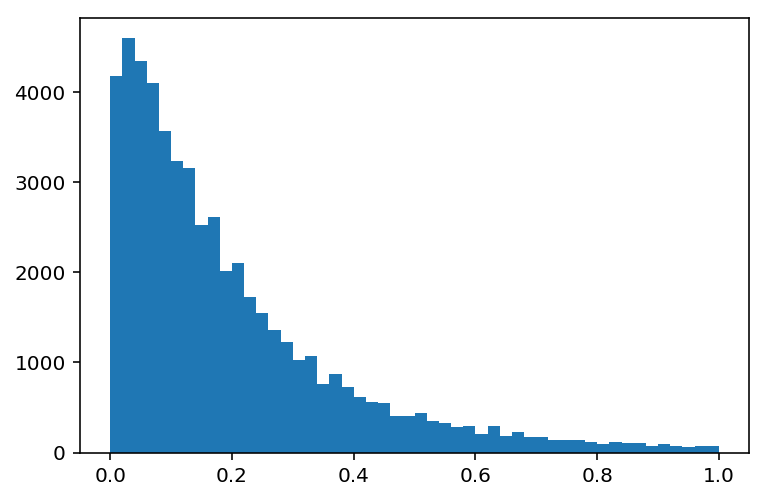

In [20]:
plt.hist(np.abs(prediction - y), 50, range=(0, 1))

In [21]:
list(zip(y_labels, prediction_labels))[:100]

[('G7V', 'G6.2V'),
 ('A0V', 'A1.5V'),
 ('F5V', 'F7.5V'),
 ('F3V', 'F4.1V'),
 ('F5V', 'F9.4V'),
 ('G5V', 'G3V'),
 ('B9V', 'A0.6V'),
 ('G3V', 'G2.8V'),
 ('A8V', 'A2.9V'),
 ('G6V', 'G4.8V'),
 ('F3V', 'F4V'),
 ('F3V', 'F7.9V'),
 ('A0V', 'B7.5V'),
 ('F5V', 'F2.8V'),
 ('A0V', 'A2.5V'),
 ('B6V', 'B5.2V'),
 ('F5V', 'A8.8V'),
 ('K0V', 'G6.1V'),
 ('F7V', 'F8.4V'),
 ('G0V', 'G0.2V'),
 ('G2V', 'F4.4V'),
 ('F0V', 'A9.4V'),
 ('A9V', 'F0.2V'),
 ('A9V', 'A8.6V'),
 ('F8V', 'F7.5V'),
 ('F5V', 'F5.5V'),
 ('A9V', 'A9.7V'),
 ('A6V', 'A3.6V'),
 ('A1V', 'A1V'),
 ('F2V', 'A8.4V'),
 ('G0V', 'F8V'),
 ('A0V', 'A0.9V'),
 ('A0V', 'B9.7V'),
 ('G0V', 'G5.3V'),
 ('F2V', 'A6.8V'),
 ('G0V', 'G1.2V'),
 ('F8V', 'F8.6V'),
 ('B9V', 'A2.1V'),
 ('F0V', 'F2.1V'),
 ('A3V', 'B9.9V'),
 ('F6V', 'F5V'),
 ('A1V', 'B9.9V'),
 ('F0V', 'A9.5V'),
 ('K0V', 'G9.6V'),
 ('F7V', 'F6.1V'),
 ('K0V', 'K2.4V'),
 ('F5V', 'F5.7V'),
 ('A0V', 'A0.4V'),
 ('A0V', 'A2.8V'),
 ('F0V', 'F2.4V'),
 ('F3V', 'F7.1V'),
 ('A0V', 'A0.6V'),
 ('F7V', 'G1.6V'),
 ('

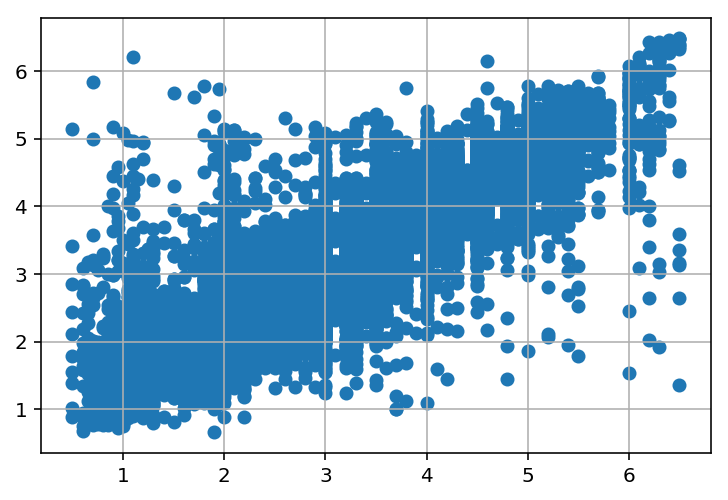

In [22]:
plt.scatter(y, prediction)
plt.grid(True)

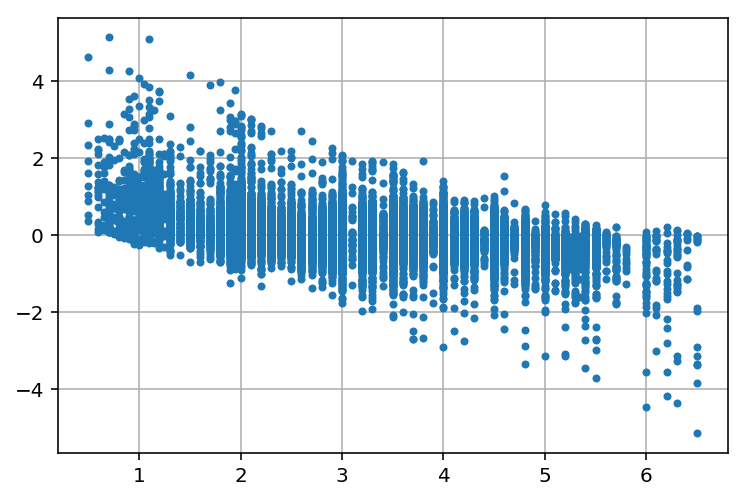

In [23]:
plt.plot(y, prediction - y, '.')
plt.grid(True)

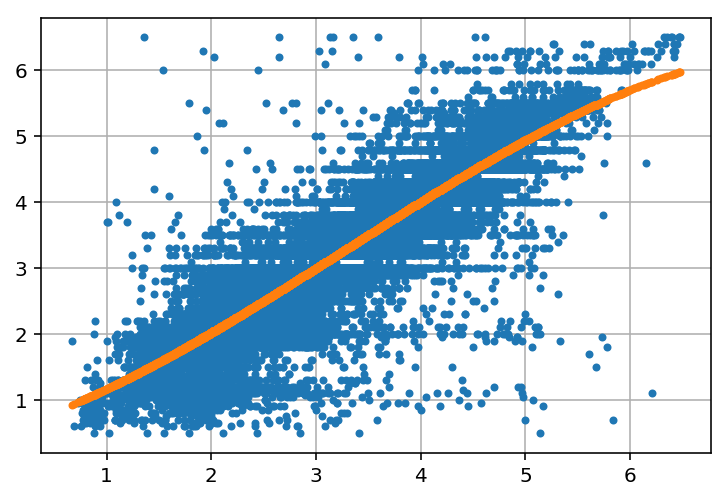

In [24]:
fit = np.poly1d(np.polyfit(prediction, y, 3))
plt.plot(prediction, y, '.')
plt.plot(prediction, fit(prediction), '.')
plt.grid(True)

In [25]:
def predict(X, clf):
    clf_prediction = clf.predict(X)
    return fit(clf_prediction)

print(y[0], predict(np.atleast_2d(X[0]), clf))

4.7 [ 4.43992578]


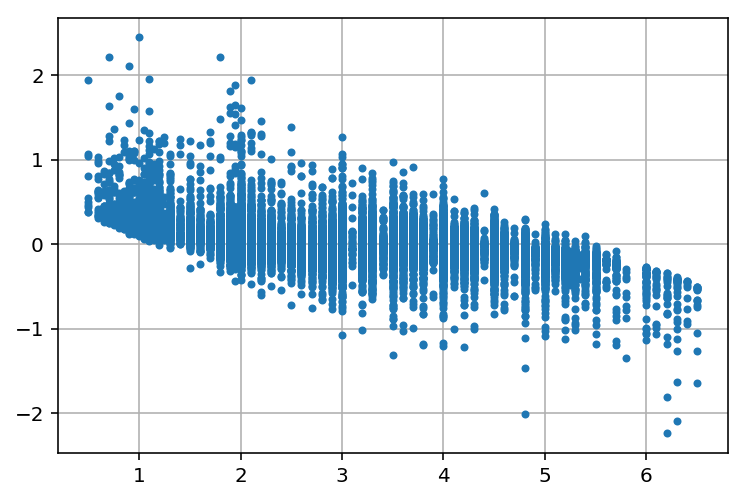

In [26]:
plt.plot(y, predict(X, clf) - y, '.')
plt.grid(True)